# Predict HR Stay or Leave

Here [HR Analytics](https://www.kaggle.com/giripujar/hr-analytics) dataset by [Giri Pujar](https://www.kaggle.com/giripujar) is used to create a classifier if a `HR` will stay or leave.

Using the `unbalanced dataset` of employees of the company to predict which employee might stay or leave the company. `SMOT` is used to deal with the unbalanced dataset. `SMOTE` (synthetic minority oversampling technique) is one of the most commonly used `oversampling` methods to solve the imbalance problem.

![](https://media.giphy.com/media/l0DAI7ZQCXxSZzaO4/giphy.gif)

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, learning_curve,
    train_test_split
)
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score, log_loss,
    precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, 
    auc
)
from sklearn.pipeline import Pipeline

# Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

from joblib import dump

In [2]:
# For seaborn colors
sns.set(style='whitegrid', color_codes=True)

In [3]:
# Loading the dataset
df = pd.read_csv('/kaggle/input/hr-analytics/HR_comma_sep.csv')
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
3381,0.55,0.69,3,225,2,0,0,0,sales,medium
967,0.85,0.92,4,275,5,0,1,0,support,medium
6266,0.72,0.81,4,200,2,0,0,0,marketing,low
10055,0.31,0.37,2,104,3,1,0,0,support,medium
12235,0.83,0.85,4,255,5,0,1,0,management,low


## Data preparation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


No missing data

In [5]:
def plot_countplot(column, ax=None):
    with sns.axes_style('ticks'):
        sns.countplot(x=column, palette=sns.color_palette('rocket'), ax=ax)
        sns.despine(offset=6)

HR stay - 76.19%
HR leave - 23.81%


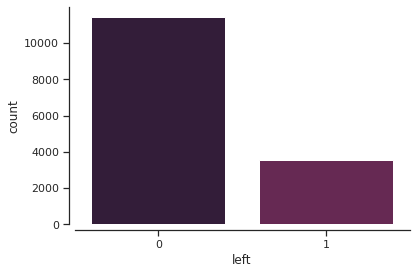

In [6]:
# Looking at how much is the dataset imbalanced?

num_of_stay = round(len(df[df.left == 0]) / len(df) * 100, 2)
print(f'HR stay - {num_of_stay}%')
print(f'HR leave - {round(100 - num_of_stay, 2)}%')

plot_countplot(df.left)

`Nominal data` assigns names to each data point without placing it in some sort of order. For example, the results of a test could be each classified nominally as a **pass** or **fail**.

`Ordinal data` groups data according to some sort of ranking system: it orders the data. For example, test results could be grouped in descending order by grade: **A, B, C, D, E and F**

More on difference between `nominal data` and `ordinal data` 👉 [Source](https://sciencing.com/difference-between-nominal-ordinal-data-8088584.html)

### Working with ordinal data like the salary coloumn

In [7]:
replacement = {
    'low': 0, 
    'medium': 1, 
    'high': 2
}

df.salary = df.salary.apply(lambda x: replacement[x])
df.salary[:5]

0    0
1    1
2    1
3    0
4    0
Name: salary, dtype: int64

### Working with nominal data like deparment column

In [8]:
ohe = OneHotEncoder()

dept_ohe_df = pd.DataFrame(df.Department)
dept_ohe_df = pd.DataFrame(
    ohe.fit_transform(dept_ohe_df[['Department']]).toarray()
)

print(f'Unique Departments: {len(df.Department.unique())}')

Unique Departments: 10


In [9]:
col_names = []
for col_name in ohe.get_feature_names():
    col_name = col_name.split('_')[1]
    col_names.append(col_name)

col_names


['IT',
 'RandD',
 'accounting',
 'hr',
 'management',
 'marketing',
 'product',
 'sales',
 'support',
 'technical']

In [10]:
dept_ohe_df.columns = col_names
dept_ohe_df.head()

,IT,RandD,accounting,hr,management,marketing,product,sales,support,technical
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Removing one column from `dep_ohe_df` to avoid multi-corrliearity

In [11]:
dept_ohe_df = dept_ohe_df.drop(['IT'], axis='columns')
dept_ohe_df.head()

,RandD,accounting,hr,management,marketing,product,sales,support,technical
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# Target column
y = df[['left']]
y.head()

,left
0,1
1,1
2,1
3,1
4,1


In [13]:
# Adding the ohe results and removing `left` column

df = df.drop(['Department', 'left'], axis='columns')
df = pd.concat([dept_ohe_df, df], axis='columns')
df.head()

,RandD,accounting,hr,management,marketing,product,sales,support,technical,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.38,0.53,2,157,3,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.80,0.86,5,262,6,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.11,0.88,7,272,4,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.72,0.87,5,223,5,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.37,0.52,2,159,3,0,0,0


In [14]:
x = df.copy()
x.head()

,RandD,accounting,hr,management,marketing,product,sales,support,technical,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.38,0.53,2,157,3,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.80,0.86,5,262,6,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.11,0.88,7,272,4,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.72,0.87,5,223,5,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.37,0.52,2,159,3,0,0,0


## Modelling

In [15]:
# Scaling the dataset
for column in x.columns:
    x[column] = StandardScaler().fit_transform(x[column].values.reshape(-1, 1))
    
x.head()

,RandD,accounting,hr,management,marketing,product,sales,support,technical,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
0,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,-0.936495,-1.087275,-1.462863,-0.882040,-0.341235,-0.411165,-0.147412,-0.933368
1,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,0.752814,0.840707,0.971113,1.220423,1.713436,-0.411165,-0.147412,0.636092
2,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,-2.022479,0.957554,2.593763,1.420657,0.343655,-0.411165,-0.147412,0.636092
3,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,0.431041,0.899131,0.971113,0.439508,1.028546,-0.411165,-0.147412,-0.933368
4,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655,-0.976716,-1.145699,-1.462863,-0.841993,-0.341235,-0.411165,-0.147412,-0.933368


### Balancing the unbalanced data

In [16]:
# Creating train and test datasets using x and y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

# Creating train and cross-validation datasets using the x_train and y_train
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

print(f'Training set size: {len(x_train)}')
print(f'Validation set size: {len(x_cv)}')
print(f'Test set size: {len(x_test)}')

Training set size: 8399
Validation set size: 2100
Test set size: 4500


Splitting the train dataset into train and cross validation data sets before oversampling to avoid `oversampling to bleed data` for cross_val_score.

In [17]:
# Oversampling to balance the data

_smote = SMOTE(random_state=0)

sm_cols = x_train.columns

x_train, y_train = _smote.fit_resample(x_train, y_train)
x_train = pd.DataFrame(data=x_train, columns=sm_cols)
y_train = pd.DataFrame(data=y_train, columns=['left'])

# We can Check the numbers of our data
print(f'Length of oversampled data is {len(x_train)}')

print(f'Number of left no {len(y_train[y_train.left == 0])}')
print(f'Number of left yes {len(y_train[y_train.left == 1])}')

print(f'Proportion of left no data in oversampled data is {len(y_train[y_train.left == 0])/len(x_train)}')
print(f'Proportion of left yes data in oversampled data is {len(y_train[y_train.left == 1])/len(x_train)}')

Length of oversampled data is 12838
Number of left no 6419
Number of left yes 6419
Proportion of left no data in oversampled data is 0.5
Proportion of left yes data in oversampled data is 0.5


### Featrue Selection

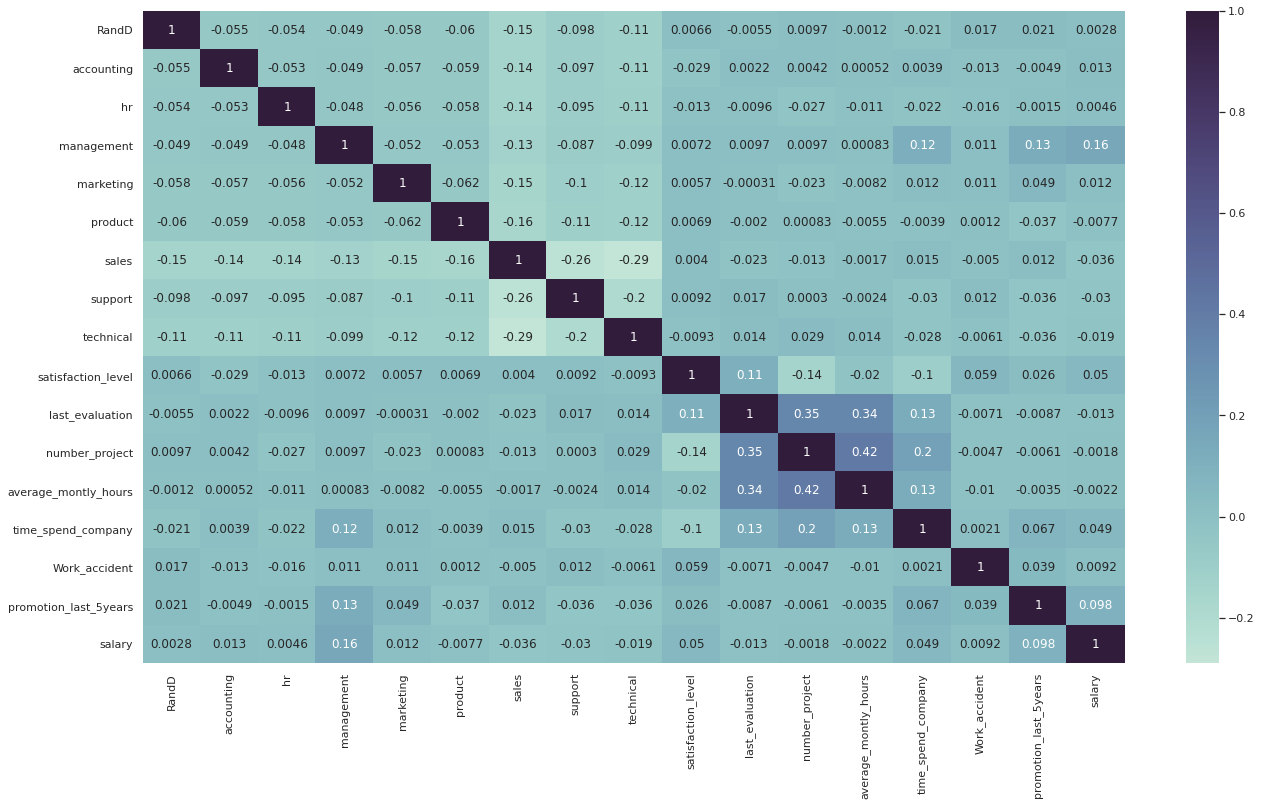

In [18]:
# Using Pearson Correlation

plt.figure(figsize=(22, 12))
cor = x.corr()
sns.heatmap(cor, annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
plt.show()

In [19]:
# For cross validation
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [20]:
col_names.remove('IT') # since IT is dropped
col_names

['RandD',
 'accounting',
 'hr',
 'management',
 'marketing',
 'product',
 'sales',
 'support',
 'technical']

In [21]:
x_cv = np.array(x_cv)
x_cv = x_cv.astype('int')
y_cv = np.array(y_cv)

In [22]:
models = [
    LogisticRegression(), 
    SGDClassifier(), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
]

In [23]:
def cross_val_score(models, x_cv, y_cv):
    for model in models:
        scores = []
        for train, test in skf.split(x_cv, y_cv):
            x_train, x_test = x_cv[train], x_cv[test]
            y_train, y_test = y_cv[train], y_cv[test]

            _smote = SMOTE(random_state=0)
            x_train_sm, y_train_sm = _smote.fit_resample(x_train, y_train)

            model.fit(x_train_sm, y_train_sm)

            score = model.score(x_test, y_test)
            scores.append(score)

        print(f'== {model} ==')
        print(f'Cross-Validation mean-score: {np.mean(score)}')
        print()


cross_val_score(models, x_cv, y_cv)

== LogisticRegression() ==
Cross-Validation mean-score: 0.8142857142857143

== SGDClassifier() ==
Cross-Validation mean-score: 0.8333333333333334

== KNeighborsClassifier() ==
Cross-Validation mean-score: 0.9047619047619048

== GaussianNB() ==
Cross-Validation mean-score: 0.5571428571428572

== DecisionTreeClassifier() ==
Cross-Validation mean-score: 0.9571428571428572

== RandomForestClassifier() ==
Cross-Validation mean-score: 0.9619047619047619

== SVC() ==
Cross-Validation mean-score: 0.9333333333333333



### Recursive Feature Elimination

In [24]:
rfe = RandomForestClassifier()

rfe = RFE(rfe, n_features_to_select=5)
rfe.fit(x_train, y_train.values.ravel())

selector = rfe.support_

print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False  True  True  True
  True  True False False False]
[ 9 10  7 11 12 13  4  6  5  1  1  1  1  1  3  8  2]


Here we took RandomForestClassifier model with 5 features and RFE gave feature ranking as above, but the selection of number ‘5’ was random. Now we need to find the optimum number of features, for which the accuracy is the highest. We do that by using loop starting with 1 feature and going up to 18. We then take the one for which the accuracy is highest.

In [25]:
len(x.columns)

17

In [26]:
def rfe(model, x_cv, y_cv):
    # number of features
    nof_list = np.arange(1, 17 + 1)
    high_score = 0

    # variable to store the optimum features
    nof = 0
    score_list = []

    for n in range(len(nof_list)):
        x_train, x_test, y_train, y_test = train_test_split(
            x_cv, y_cv, test_size=0.3, random_state=0
        )

        _smote = SMOTE(random_state=0)
        x_train_sm, y_train_sm = _smote.fit_resample(x_train, y_train)

        rfe = RFE(model, n_features_to_select=nof_list[n])
        x_train_rfe = rfe.fit_transform(x_train_sm, y_train_sm)
        x_test_rfe = rfe.transform(x_test)

        model.fit(x_train_rfe, y_train_sm)

        score = model.score(x_test_rfe, y_test)
        score_list.append(score)

        if score > high_score:
            high_score = score
            nof = nof_list[n]

    return (nof, high_score)


nof, high_score = rfe(RandomForestClassifier(), x_cv, y_cv)

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.957143


As seen from above code, the optimum number of features is `nof`. We now feed `nof` as number of features to RFE and get the final set of features given by RFE method, as follows

### Performing Feature Elimination

In [27]:
model = RandomForestClassifier()

rfe = RFE(model, n_features_to_select=nof)
rfe.fit(x_train, y_train.values.ravel())

selector = rfe.support_

print(rfe.support_)
print(rfe.ranking_)

num_of_selected_features = len(rfe.support_)
print(f'\nNumber of features selected: {num_of_selected_features}')

[False False False False False False False False False  True  True  True
  True  True  True False  True]
[ 8  7  5  9 10 11  2  4  3  1  1  1  1  1  1  6  1]

Number of features selected: 17


In [28]:
# Selected features

col = (x_train.columns)
result = itertools.compress(col, selector)

col_names = []
for c in result:
    col_names.append(c)
    print(c)

satisfaction_level
last_evaluation
number_project
average_montly_hours
time_spend_company
Work_accident
salary


In [29]:
x_train = x_train[col_names]
x_test = x_test[col_names]

len(col_names)

7

In [30]:
# Implementing the model

cols = col_names.copy()

x_train = x_train[cols]
y_train = y_train['left']

logit_model = sm.Logit(y_train, x_train)

result = logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.541671
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.219     
Dependent Variable:   left              AIC:               13921.9511
Date:                 2021-04-02 07:33  BIC:               13974.1722
No. Observations:     12838             Log-Likelihood:    -6954.0   
Df Model:             6                 LL-Null:           -8898.6   
Df Residuals:         12831             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
satisfaction_level   -0.9709   0.0234 -41.4969 0.0000 -1.0168 -0.9251
last_evaluation 

Every Feature that we got from `Recursive Feature Elimination` is selected since no feature's `p-value is greater that 0.05`.

### Creating the model

In [31]:
def rt_param_selection(x, y, nfolds):
    criterion = ['gini', 'entropy']
    max_features = ['auto', 'sqrt', 'log2']
    param_grid = {'criterion': criterion, 'max_features': max_features}

    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=nfolds)
    grid_search.fit(x, y)
    grid_search.best_estimator_
    return grid_search.best_estimator_


skf = StratifiedKFold(n_splits=10)
best_estimator_ = rt_param_selection(x_train, y_train, skf)
best_estimator_

RandomForestClassifier(criterion='entropy', max_features='log2')

In [32]:
cross_val_score(best_estimator_, x_cv, y_cv)

== DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=1716001901) ==
Cross-Validation mean-score: 0.9333333333333333

== DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=576578122) ==
Cross-Validation mean-score: 0.9238095238095239

== DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=1167233644) ==
Cross-Validation mean-score: 0.9285714285714286

== DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=1138618173) ==
Cross-Validation mean-score: 0.9285714285714286

== DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=1640905621) ==
Cross-Validation mean-score: 0.9333333333333333

== DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       random_state=266738659) ==
Cross-Validation mean-score: 0.928571428571

In [33]:
# Plotting learning curve

_size = np.arange(0.01, 1.01, 0.01)
train_sizes = np.array(_size)
scoring = 'neg_mean_squared_error'

train_sizes_abs, train_scores, cv_scores = learning_curve(
    RandomForestClassifier(criterion='entropy'), 
    x_train, y_train, 
    train_sizes=train_sizes, cv=skf, scoring=scoring
)

In [34]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)

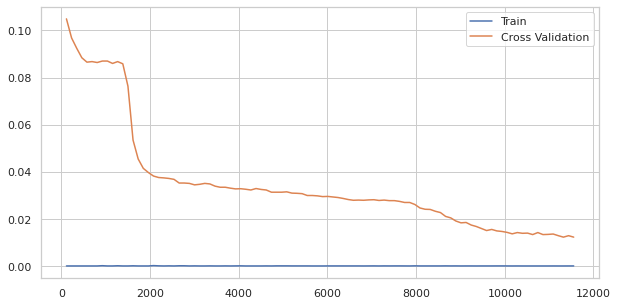

In [35]:
f, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_sizes_abs, train_scores_mean, label='Train')
ax.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

ax.legend()

In [36]:
# Fitting the model
model = best_estimator_
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2')

## Evaluation

In [37]:
y_test_pred = model.predict(x_test)
print(y_test_pred)
print(f"\nPrediction: \n{pd.DataFrame(y_test_pred)[0].value_counts()}")

[0 1 0 ... 1 0 0]

Prediction: 
0    3471
1    1029
Name: 0, dtype: int64


In [38]:
print(y_test.values.reshape(1, -1)[0])
print()
print(f"Actual: \n{pd.DataFrame(y_test)['left'].value_counts()}")

[0 1 0 ... 1 0 0]

Actual: 
0    3408
1    1092
Name: left, dtype: int64


In [39]:
y_test_prob = model.predict_proba(x_test)
y_test_prob

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [40]:
print(f'Model Score: {model.score(x_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9828888888888889
f1-score: 0.982713117888326
precision score: 0.9830759901771138
recall score: 0.9828888888888889


In [41]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


print(confusion_matrix(y_test, y_test_pred, labels=[1, 0]))

[[1022   70]
 [   7 3401]]


Confusion matrix, without normalization
[[1022   70]
 [   7 3401]]


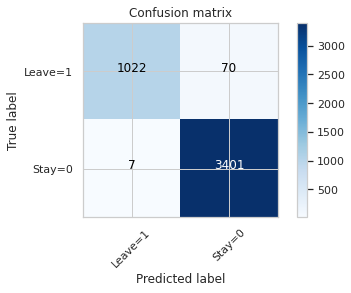

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Leave=1','Stay=0'], normalize= False,  title='Confusion matrix')

In [43]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3408
           1       0.99      0.94      0.96      1092

    accuracy                           0.98      4500
   macro avg       0.99      0.97      0.98      4500
weighted avg       0.98      0.98      0.98      4500



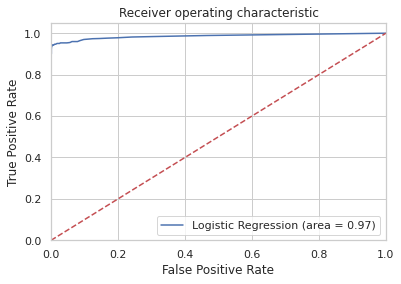

In [44]:
logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# The blue farther from red-dotted the better model

### Pipeline

In [45]:
scaling = ('scale', StandardScaler())
model = ('model', RandomForestClassifier(criterion='entropy'))

# Steps in the pipeline
steps = [scaling, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(x_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(x_test)

# Evaluation
print(f'Model Score: {model.score(x_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9833333333333333
f1-score: 0.9831678101813365
precision score: 0.9835070161404643
recall score: 0.9833333333333333


### Precision-Recall vs Threshold Chart

(0.0, 1.0)

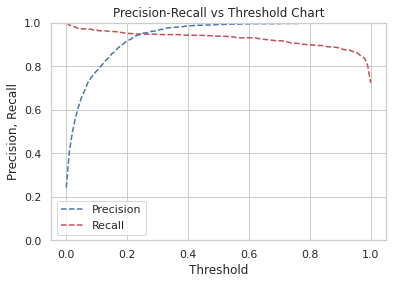

In [46]:
log_pred_y = model.predict(x_test) 
log_probs_y = model.predict_proba(x_test) 

precision, recall, thresholds = precision_recall_curve(y_test, log_probs_y[:, 1]) 
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### To control the threshold of probability abpve which we want to consider it has true

Confusion matrix, without normalization
[[1028   64]
 [  10 3398]]
                      0
accuracy       0.983556
recall         0.941392
precision      0.990366
f1_score       0.965258
roc_auc_score  0.969229


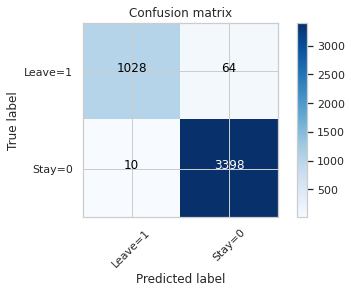

In [47]:
THRESHOLD = 0.45
preds = np.where(model.predict_proba(x_test)[:,1] > THRESHOLD, 1, 0)

results_data = [
    accuracy_score(y_test, preds), 
    recall_score(y_test, preds), 
    precision_score(y_test, preds), 
    f1_score(y_test, preds), 
    roc_auc_score(y_test, preds)
]
results_indexes = ["accuracy", "recall", "precision", "f1_score", "roc_auc_score"]
results = pd.DataFrame(data=results_data, index=results_indexes)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Leave=1','Stay=0'], normalize= False,  title='Confusion matrix')

print(results)

In [48]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/qatu2fd5vCi7C/giphy.gif)

---